<script type="text/x-mathjax-config">
MathJax.Hub.Config({
  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}
});
</script>
<script type="text/javascript" async src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-MML-AM_CHTML"></script>
While wandering around at [kaggle.com](https://www.kaggle.com/), I encountered the [2016 New Coder Survey](https://www.kaggle.com/freecodecamp/2016-new-coder-survey-) dataset. It's a survey targeted at people learning to code.

The survey included a question asking the participants what's the job role they're interested in. I was curious to know whether there's an association between a new coder's age and the job role he dreams of.

In this post I'll try to answer this question. The post will be a technical post, in which I'll walk you through data exploration, how to approach our research question, and what statistical tests can be used in order to find the answer.

First, let's import some stuff:

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('2016-FCC-New-Coders-Survey-Data.csv')

For the purpose of our research question, respondents who didn't specify their age have no value for us.

On the contrary, respondents who did specify their age but didn't specify the job role do give us general information about the age of new coders.

In [2]:
data = data[data['Age'].notnull()]
data['JobRoleInterest'] = data['JobRoleInterest'].fillna('unspecified').map(lambda job: job.strip())

Let's inspect the general ages of the respondents:

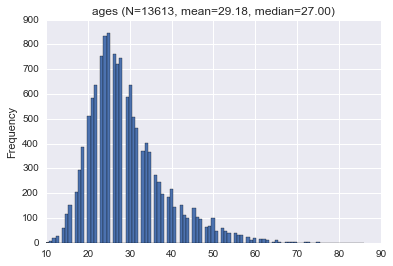

In [3]:
data['Age'].plot.hist(title='ages (N=%d, mean=%.2f, median=%.2f)' % (len(data), data['Age'].mean(), data['Age'].median()),
                     bins=100)

We can see the data looks almost normal. The mean is greater than the median, which according to [nonparametric skewness](https://en.wikipedia.org/wiki/Nonparametric_skew) definition implies the distribution has right skewness. It means there are more older people learning to code than younger people (compared to the mean age of about 29).

An interesting thing to note is that my wife is also learning to code as I'm writing this post; and she's the age of 29, as the mean age. I guess it'll help me remember that...

# Drilling down
Let's explore the average age within the groups of respondents, where each group is defined by the job role of interest.

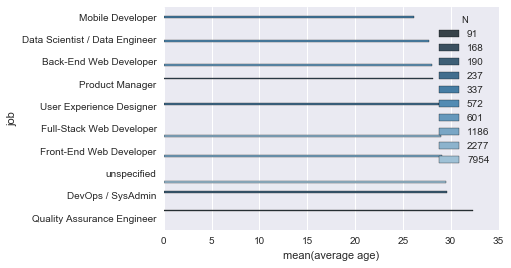

In [4]:
average_ages = pd.DataFrame([{
            'job': group,
            'N': len(data.loc[rows]),
            'average age': data.loc[rows]['Age'].mean()
        } for group, rows in data.groupby('JobRoleInterest').groups.items()]).sort_values(by='average age')
sns.barplot(data=average_ages, x='average age', y='job', hue='N', palette='Blues_d')

Each group has a bar with a length equal to the group's mean age. The bigger the group is, the lighter the color of the bar gets.

I chose to focus on the Quality Assurance engineers group. They have a mean age bigger than the rest of the groups, of about 32 years. It's interesting to see if this effect is due to chance, or maybe the desire to be a QA engineer is more likely to be associated with older people on average.

Let me explain what "due to chance" means: remember that we have limited data. It tells the story of only a fraction of the population of new coders. Specifically, we only have data of 91 QA engineers. In reality there are more new coders who want to be QA engineers: there are those who didn't participate in the survey, and there are the future new coders who haven't even started to learn how to code yet. 32 years is the new coders QA engineers **sample mean**. We're interested to know if the new coders QA **population mean** is bigger than other new coders **population mean**. We don't have data of the entire population, so the best we can do is to estimate their mean. We do this by using the sample mean. The sample mean is a random variable; it depends on the sample we’ve got. We could have gotten some other sample of QA engineers, and the sample mean would have been different. The population mean on the other hand is a non random parameter of the distribution.

Given the new coders sample we have, there are two complementary possibilities:
1. The QA population's mean age equals to general new coders population's mean age.
2. They are different.

The sample supports the second option, but it could be due to chance (especially because of the small QA sample size). Next, we'll use statistical tests to quantify how likely it is to observe such a difference due to chance.

# Statistical framework
For the uninitiated reader, many statistical tests work as follows: one first states a null hypothesis, which is the default option that can describe the world. In our case, the null hypothesis is that there's no difference between QA engineers mean age and other new coders mean age. Then, an alternative hypothesis is stated. In our case the alternative is that a difference does exist. Afterwards, a test statistic (a function of the data) is calculated. Assuming the null hypothesis is true, the distribution of the test statistic is known, and the probability to observe the value at hand of the test statistic can be calculated. This probability is called p-value. If the p-value is smaller than a significance level we decide before running the experiment (e.g. 0.01), the null hypothesis is rejected in favor of the alternative hypothesis.

# Z-Test
Assuming the ages are normally distributed, we can use the Z-Test (note that even if they're not normally distributed, we can harness the central limit theorem and use the fact that the mean age is approximately normally distributed).

If we knew the mean age's standard deviation, we could normalize the mean age in the following way:

$Z = \frac{\bar{X} - \mu}{\sigma}$

$\bar{X}$ is the observed mean age. $\mu$ is the expected mean age given the null hypothesis is true. In our case, we choose the general new coders sample mean age of 29.18 to be $\mu$. Note there are better ways of estimating $\mu$ (and more suitable statistical tests, e.g. - two-sample T-Test, which I choose not to describe in this post to keep it simple), but for the sake of simplicity I'll stick to 29.18; since I have a lot of data I think it's a good enough estimator.

$Z$ is a normalized normal random variable: $Z \sim Norm(0, 1)$. As such, given the observed value of the $\bar{X}$, we can calculate its probability, and see if it's below a reasonable threshold. If it does - we'll reject the null hypothesis.

Z-Test assumes we know $\sigma$. Well, we don't. Despair not, T-Test for the rescue!

# T-Test

T-Test is the same as Z-test, with the difference of not knowing $\sigma$. It works as follows:

$T = \frac{\bar{X} - \mu}{\left.s \, \middle/ \sqrt{N} \right.}$

$s$ is the sample standard deviation of the age. $\left.s \, \middle/ \sqrt{N} \right.$ is the sample standard deviation of the mean age (where $N$ is the number of samples). You can read how it's derived [here](https://en.wikipedia.org/wiki/Variance#Sum_of_uncorrelated_variables_.28Bienaym.C3.A9_formula.29).

You can see this statistic is very similar to the one calculated at the Z-Test... The T statistic is distributed according to the [T distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution). The T distribution arises whenever the variance of a normally distributed random variable is unknown.

It has one parameter called the degrees of freedom. I won't go into details about that, but intuitively it captures the amount of data used for estimating the parameter. In our case, where $\sigma$ is the parameter being estimated, the degrees of freedom is $N - 1$.

The T distribution approaches the normal distribution as the degrees of freedom approaches infinity.

We'll use `scipy` in order to calculate this probability:

In [5]:
qa = average_ages[average_ages['job'] == 'Quality Assurance Engineer'].iloc[0]
t_score = float(qa['average age'] - data['Age'].mean()) / (data['Age'].std() / np.sqrt(qa['N']))
degrees_of_freedom = qa['N'] - 1
p_value = 1 - scipy.stats.t(df=degrees_of_freedom).cdf(t_score)
print 'The p-value is', p_value

The p-value is 0.000551459304572


This number is quite small. It means that there's less than tenth percent chance that the QA engineers mean age deviation from the total population's mean age is due to chance. If we would have chosen a significance level of 0.01 (which is a common choice), we'd reject the null hypothesis.

To complicate the things a little bit, you should note that what I just did is called one sided test: we calculated the probability of observing a T score bigger than or equal to the observed value. We actually care for difference in either direction: if the QA engineers mean age was significantly smaller than the expected value (the null hypothesis) it would be interesting as well. In T test, testing for a significant difference in either direction is done by multiplying the calculated p-value by two (due to the distribution's symmetry), which gives us

In [6]:
print "The two sided test's p-value is", p_value * 2

The two sided test's p-value is 0.00110291860914


Still significant...

# Simulation
Statisticians like statistical tests. They are powerful, but they have two big disadvantages:
1. They impose assumptions on the data. In our case, the sample mean age isn't really normal. It's approximately normal, so the T test result is an approximation (although quite a good one).
2. Sometimes they make you test something that is similar but not exactly what you wish for. In our case it's not true: we were interested in the mean difference, and that's exactly what the T test provides. If we wanted to test something more complicated with no classical statistical test for the use case, we'd be in trouble.

To solve both problems, we can use simulations. We first calculate some statistic of the observed data (as was done before). Instead of calculating the probability to observe that statistic value, we simulate many experiments (assuming the null hypothesis is true), and we count the fraction of the experiments that yielded a statistic which is at least as extreme as the one we calculated before.

Let me explain why simulations work: if one chooses to use a statistical test whose assumptions are met, the calculated p-value is the true probability of observing a statistic at least as extreme as the one calculated from the actual data (assuming the null hypothesis is true). We can treat it as a Bernoulli trial, where the p-value is the probability of success. Performing simulations is like running the Bernoulli trial many times. The goal of running the simulations is to estimate the probability of success, which is the p-value. Using the MLE method, we simply estimate this probability to be the fraction of successes. This estimator approaches the true p-value as the number of simulations approaches infinity.

Let's try this approach in our case: the null hypothesis states that there's no difference between the QA engineers mean age and the general new coders mean age. It means that the mean age observed by the group of QA engineers might as well be observed by any random subgroup of new coders. So that's exactly what we'll do; we'll randomly sample a group of the same size as the QA engineers group and calculate the difference between their mean age and the general new coders mean age:

In [7]:
observed_diff = abs(qa['average age'] - data['Age'].mean())
num_of_simulations = 100000
num_of_extreme_values = sum(abs(data.sample(n=qa['N'])['Age'].mean() - data['Age'].mean()) >= observed_diff
                            for _ in range(num_of_simulations))
p_value = float(num_of_extreme_values) / num_of_simulations
print 'The p-value is', p_value

The p-value is 0.0007


We got a similar result, but a little bit different. Note that the more simulations we run, the more exact the result will be (it'll tend to the true p-value).

Why does it differ from the T test approach? Because the T test assumes the data is normal, while it's only approximately normal.

In the old days where computers were slow and computing power was expensive, it didn't make a lot of sense to run simulations. Nowadays however, it does make sense (in some situations, anyway). It's a nice approach which should be kept in the back of our head in case of need. I've recently read a great [post](http://allendowney.blogspot.co.il/2011/05/there-is-only-one-test.html) which further discusses the simulations approach.

# Multiple testing problem
Some of you may have noticed that my analysis is problematic: it incurs the [multiple testing problem](http://www.stat.berkeley.edu/~mgoldman/Section0402.pdf). Only after examining the data did I notice that the QA engineers mean age is higher than other groups' mean age. Then I ran a statistical test to see if it could be due to chance. The problem is that because we have multiple groups, the probability that one group will have a significant difference in mean age gets bigger the more groups we examine. There are plenty of methods to account for this problem. One option is to test an hypothesis on a dataset other than the dataset which suggested that hypothesis. Other options involve adjusting the significance level accordingly.

# Implications
Are there any implications to this analysis? First, we should distinguish statistical significance from practical significance. It might be the case that there's a statistical significance, meaning that the observed data isn't just a result of chance, a difference truly exists. Practical significance means that the difference we observed has practical implications: one can act accordingly. Practical significance depends on the problem at hand. In our case I think there's not much to do with the observed mean age difference... If general new coders were 20 years old on average while QA were 40, we could have suggested, for example, that schools for new coders should alter the timetable for the QA track because the QA students probably have kids waiting for them back home.